# Apply `scikit-learn` to Fermi sources

<h5 style="text-align:right"> 2023-06-07 05:24</h5>

Read 6699 source entries from `files/fermi_sources_v2.csv`, selected 6239 with criteria 'delta<0.2 & curvature<0.9'

## Training dataset
Select the dominant components in the associated sources for 
training: 
* Blazars, either FSRQ (fsrq) or BL Lac (bll)
* Pulsars

We will use as features the three spectral parameters and 
the BB interval count, `nbb`.

DataSet with 2537 sources<br>
*  Features: ['log_nbb', 'pindex', 'curvature', 'log_e0']<br>
* category: {'bll': 1448, 'fsrq': 781, 'psr': 308}

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f5982ebe190>
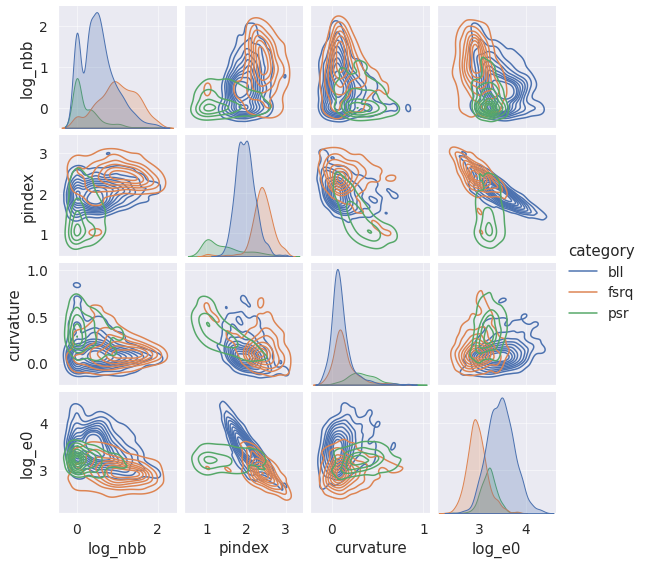

In [11]:
%run pylib/fermi_sources
show(f"""# Apply `scikit-learn` to Fermi sources""")
show_date()

fs_data = FermiSources('files/fermi_sources_v2.csv')
train = fs_data.dataset('log_nbb pindex curvature log_e0 category'.split(), 'bll fsrq psr'.split())
show(f"""## Training dataset
Select the dominant components in the associated sources for 
training: 
* Blazars, either FSRQ (fsrq) or BL Lac (bll)
* Pulsars

We will use as features the three spectral parameters and 
the BB interval count, `nbb`.
""")
show(str(train).replace('\n','<br>\n *'))
show(train.pairplot(height=2))

## The unassociated sources
Includes `abs_sin_b` and `log_eflux` not used in fit.<br>
DataSet with 1870 sources
  Features: ['log_nbb', 'pindex', 'curvature', 'log_e0', 'abs_sin_b', 'log_eflux']
 category: {'unid': 1870}

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594e258be0>
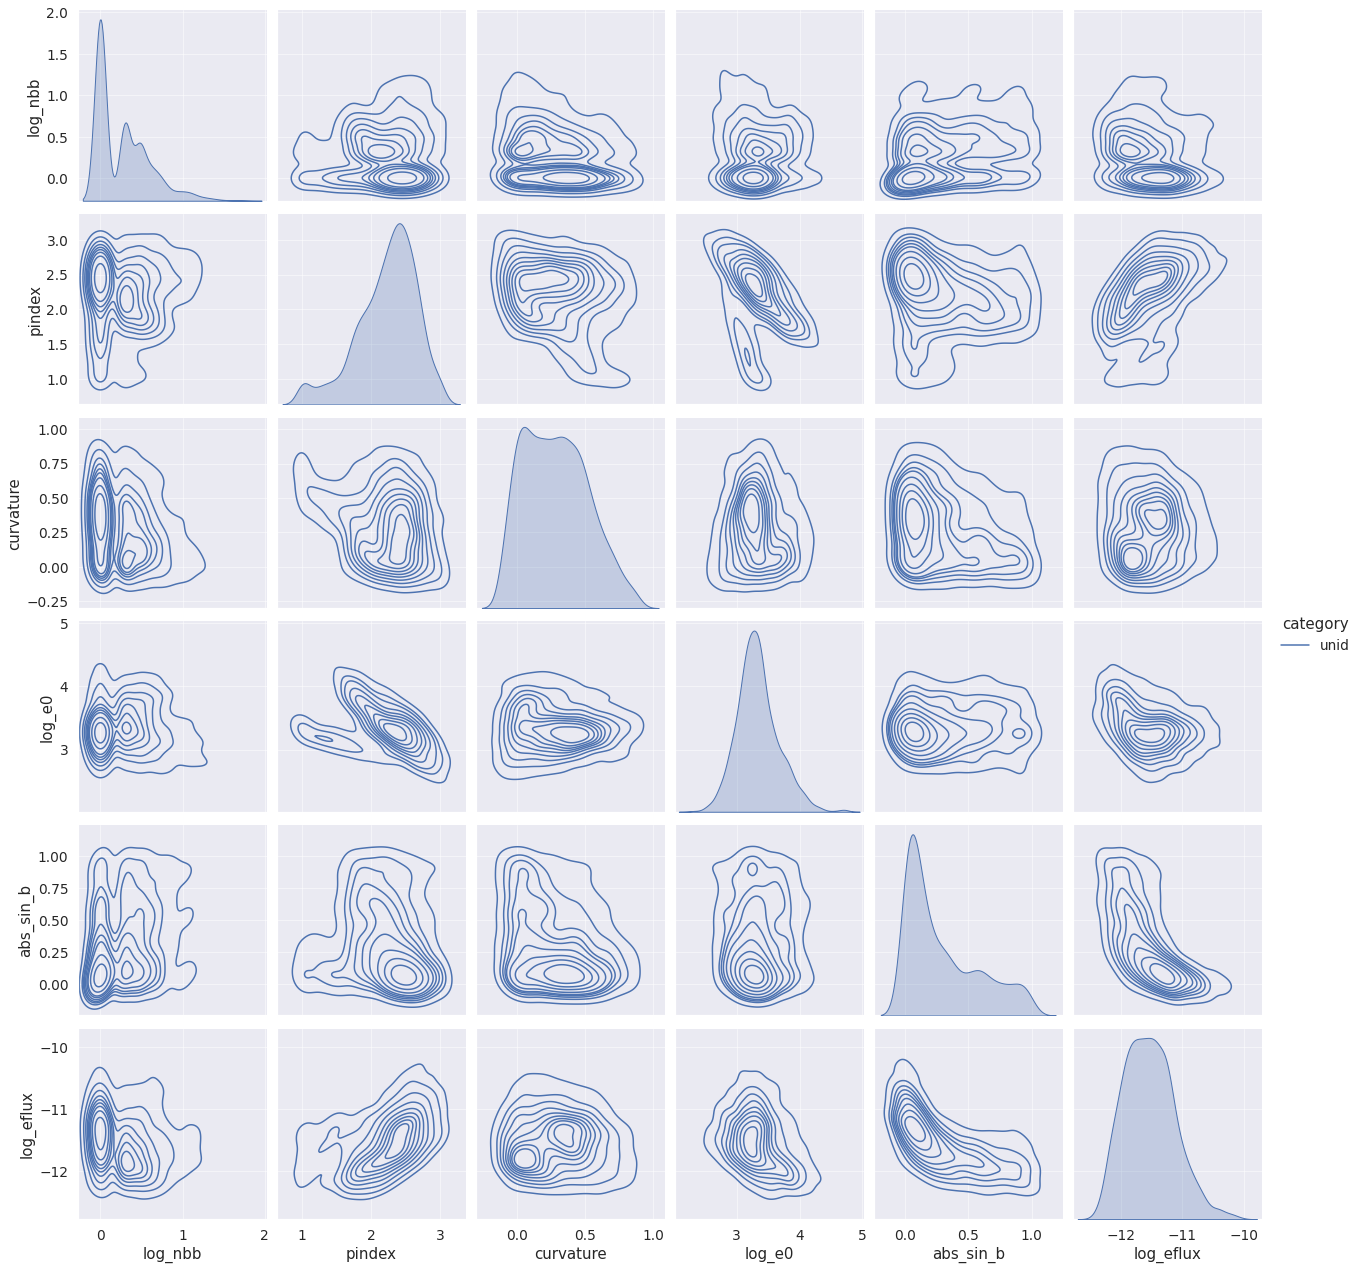

In [2]:
unid = fs_data.dataset('log_nbb pindex curvature log_e0  abs_sin_b log_eflux category'.split(), ['unid'])
show(f""" ## The unassociated sources
Includes `abs_sin_b` and `log_eflux` not used in fit.<br>
{str(unid)}""")
show(unid.pairplot(height=3))

## Use the "Gaussian Naive Bayes" model to:
* __Train__ using the training data
* __Predict__ content of the unids  

DataSet with 1870 sources<br>
*   Features: ['log_nbb', 'pindex', 'curvature', 'log_e0', 'abs_sin_b', 'log_eflux']<br>
*  category: {'bll': 791, 'fsrq': 438, 'psr': 641}

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594e21df40>
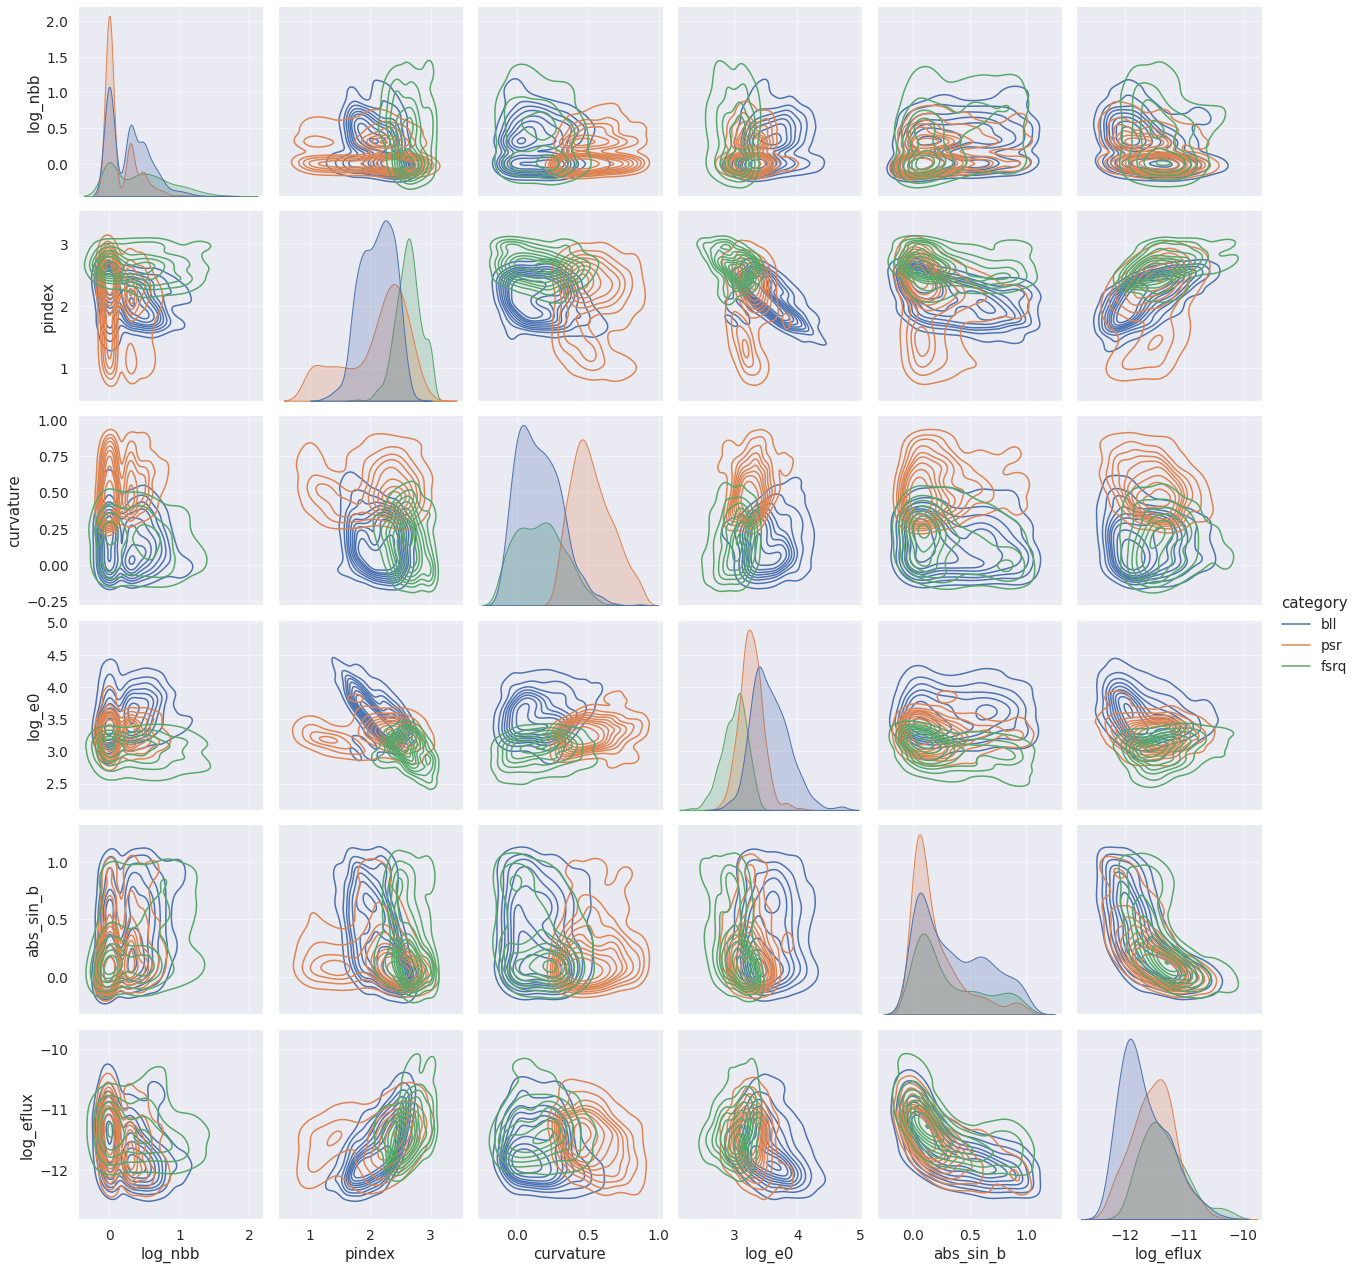

In [3]:
show(f"""## Use the "Gaussian Naive Bayes" model to:
* __Train__ using the training data
* __Predict__ content of the unids  """)
from sklearn.naive_bayes import GaussianNB 
model = GaussianNB()
classifier = train.fit(model) # make the model a classifier
unid.predict(classifier) 
# apply it to the unids
show(str(unid).replace('\n','<br>\n* '))
show(unid.pairplot(height=3))

### Pindex vs. curvature ?
Something strange with inferred psr category

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f59828534c0>
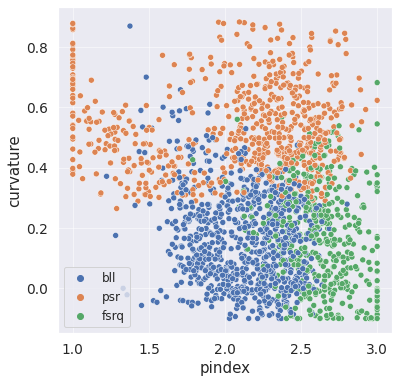

In [4]:
show(f"""### Pindex vs. curvature ?
Something strange with inferred psr category
""")
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(unid, x='pindex', y='curvature', hue='category');
ax.legend(fontsize=12);
show(fig)

### Examine the pindex-curvature correlation
This shows a clear distinction between two populations.

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f59801a88e0>
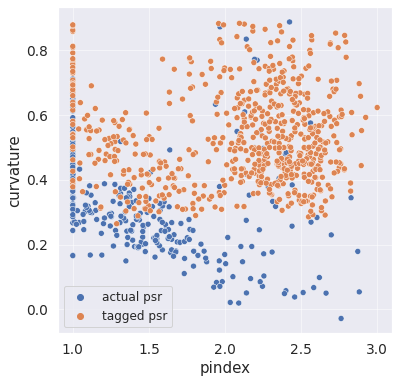

Notes: 
* KDE distorts near a boundary, scatter is better for details.
* The unid sources tagged as pulsars were fit to a log-parabola, while pulsars are all PLEX. Assuming the 
lower curvature and spectral index set are pulars, this may explain the offset. 

In [5]:
show(f"""### Examine the pindex-curvature correlation
This shows a clear distinction between two populations.""")
def psr_comparison( fs_data, unid):
    real_psr = fs_data.dataset(unid.columns,['psr']).copy()
    real_psr.category = 'actual psr'
    tagged_psr = unid.query('category=="psr"').copy()
    tagged_psr.category='tagged psr'
    return DataSet(pd.concat([real_psr,tagged_psr]))
pcompdata = psr_comparison(fs_data, unid)
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(pcompdata, x='pindex', y='curvature', hue='category', ax=ax)
ax.legend(fontsize=12)
show(plt.gcf())

show("""Notes: 
* KDE distorts near a boundary, scatter is better for details.
* The unid sources tagged as pulsars were fit to a log-parabola, while pulsars are all PLEX. Assuming the 
lower curvature and spectral index set are pulars, this may explain the offset. 
""")

### A diagonal seems to separate the two populations
Plot `(pindex-1)/2 + curvature`

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f5980467640>
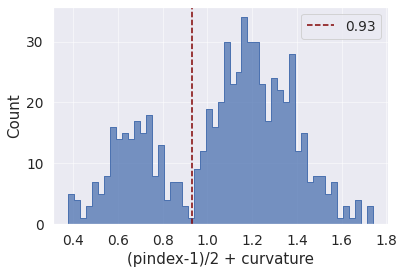

Making the cut shown, conclude that there are 185 pulsars, and 456 of this unknown spectral type.

* Retag the sources tagged as "psr" 

In [6]:
show(f"""### A diagonal seems to separate the two populations
Plot `(pindex-1)/2 + curvature`
""")
df = pcompdata.query('category=="tagged psr"')

u = (df.pindex-1)/2+ df.curvature
ax = sns.histplot(df, x=u, bins=51, element='step')
ax.axvline(0.93, ls='--', color='maroon', label='0.93');
ax.set(xlabel= '(pindex-1)/2 + curvature')
ax.legend()
show(ax.figure, caption='Showing separation')

n,m = sum(u<0.93), len(df)
show(f'Making the cut shown, conclude that there are {n} pulsars, and {m-n} of this unknown spectral type.')
show(f"""* Retag the sources tagged as "psr" """)
psrcut = unid.category=='psr'
unidx = unid.copy()
unidx.loc[psrcut & (u>0.93),'category']='X'
unidx.loc[psrcut & (u<0.93),'category']='psr-like'

* Separate tagged psr into 456 "X" sources and 185 that are Pulsar-like 

### Examine the 456 "X" sources

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594e9c21f0>
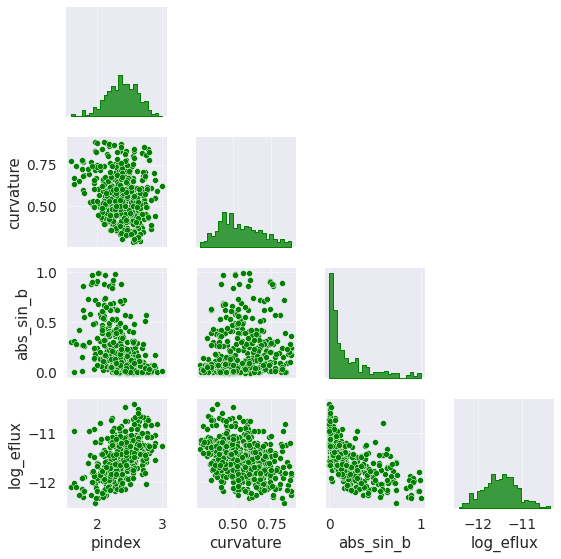

Notes:
* These are (mostly) Galactic
* Strong correlation between latitude and flux

In [7]:
xsrc, psrc = [unidx[psrcut].query(f'category == "{cat}"') for cat in 'X psr-like'.split().copy()]

show(f"""* Separate tagged psr into {len(xsrc)} "X" sources and {len(psrc)} that are Pulsar-like """)
show(f"""### Examine the {len(xsrc)} "X" sources""")
xds = DataSet(unid.loc[xsrc.index])
g = sns.PairGrid(xds, vars='pindex curvature abs_sin_b log_eflux'.split(), 
                 corner=True, despine=True, height=2, )
g.map_diag(sns.histplot,element='step', color='green',bins=25)
g.map_offdiag(sns.scatterplot, color='green')     
show(plt.gcf())
show(f"""Notes:
* These are (mostly) Galactic
* Strong correlation between latitude and flux
""")

## Sky plots of the unassociated sources

### The 456 "X" sources

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594e61cd00>
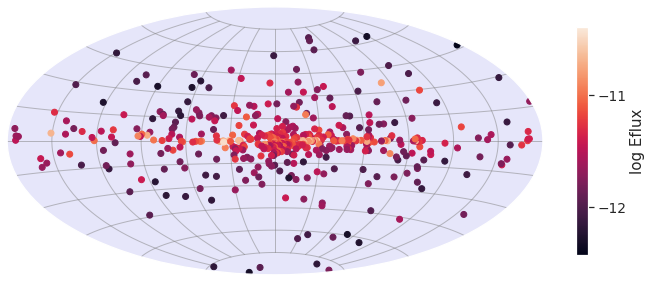

### The 185 psr-like sources

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f598043f040>
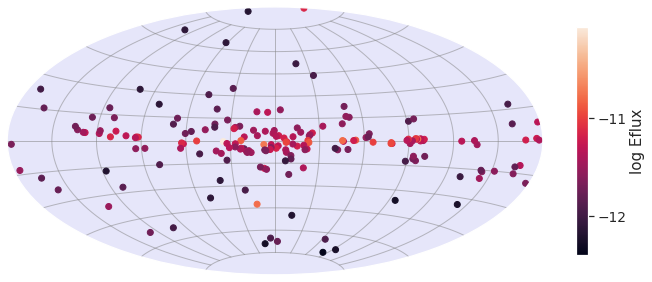

### The 791 bll-like sources

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f5980530b80>
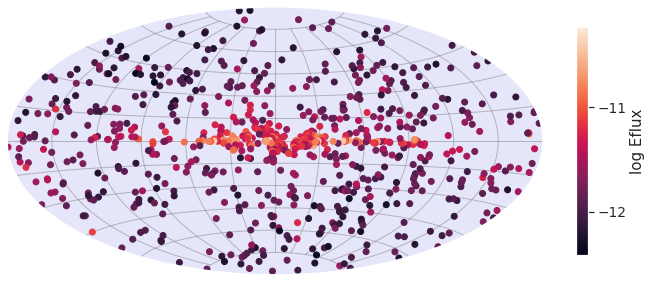

### The 438 fsrq-like sources

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f59491698b0>
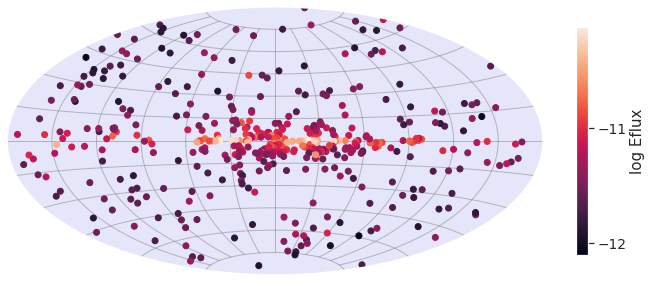

In [8]:
show("""## Sky plots of the unassociated sources""")
bsrc = unidx.query('category=="bll" | category=="fsrc"')
bll = unidx.query('category=="bll"')
fsrq = unidx.query('category=="fsrq"')
for src, label in [(xsrc, '"X"'), (psrc, 'psr-like'), (bll, 'bll-like'),(fsrq, 'fsrq-like')]:
    show(f"""### The {len(src)} {label} sources""")
    fs_data.show_positions(src) 


## Associated sky plots

### psr: 

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594ee31b80>
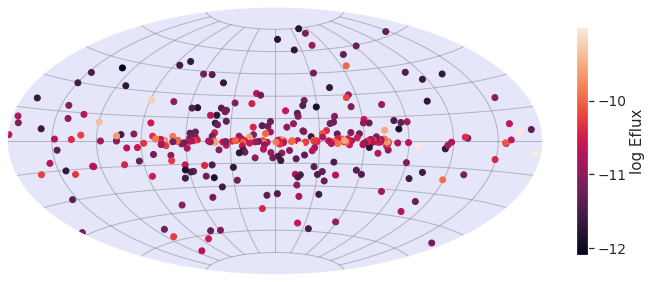

### bll: 

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f594e250160>
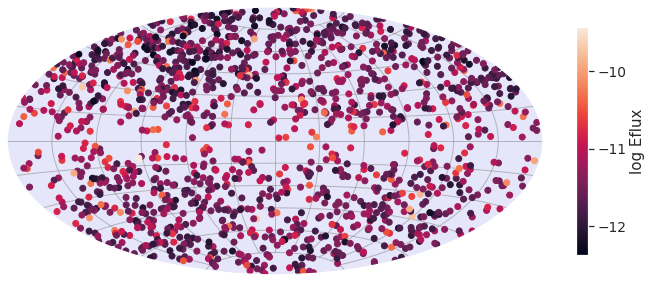

### fsrq: 

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f5982d88910>
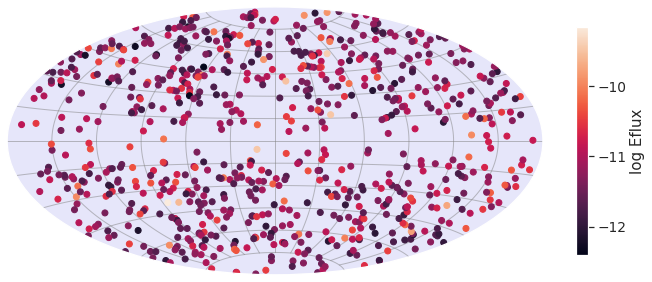

In [9]:
show(f"""## Associated sky plots""")
for cat in 'psr bll fsrq'.split():
    show(f"""### {cat}: """)
    fs_data.show_positions(fs_data.df.query(f'category=="{cat}"'));

In [10]:
outfile= 'files/unid_table.csv'
show(f"""## Write unid info to {outfile}""")
self=fs_data
unid_coord = SkyCoord(pd.Series(self.skycoord, index=self.df.index)[unidx.index].values)
out_df = pd.concat([unidx, fs_data.df.loc[unidx.index, 'ts r95 glat uw_name'.split()]], axis=1)
out_df['ra']  = unid_coord.fk5.ra.deg
out_df['dec'] = unid_coord.fk5.dec.deg
out_df.to_csv(outfile, float_format='%.6f')

## Write unid info to files/unid_table.csv